In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization


In [2]:
data = pd.read_csv("computer_prices_all.csv")
data

,device_type,brand,model,release_year,os,form_factor,cpu_brand,cpu_model,cpu_tier,cpu_cores,...,resolution,refresh_hz,battery_wh,charger_watts,psu_watts,wifi,bluetooth,weight_kg,warranty_months,price
0,Desktop,Samsung,Samsung Forge XDI,2022,Windows,ATX,Intel,Intel i5-11129,3,12,...,2560x1440,90,0,0,750,Wi-Fi 6,5.1,11.00,36,1383.99
1,Laptop,Samsung,Samsung Pro KM8,2022,Windows,Mainstream,Intel,Intel i7-11114,4,12,...,1920x1080,90,56,120,0,Wi-Fi 6,5.3,2.03,12,2274.99
2,Desktop,Lenovo,Lenovo Strix BIE,2024,macOS,SFF,AMD,AMD Ryzen 5 5168,2,8,...,3440x1440,120,0,0,850,Wi-Fi 6,5.0,7.00,24,1879.99
3,Desktop,Dell,Dell Cube AXR,2024,Windows,ATX,AMD,AMD Ryzen 5 7550,2,6,...,3440x1440,120,0,0,650,Wi-Fi 6,5.2,6.00,36,1331.99
4,Laptop,Gigabyte,Gigabyte Pro IX1,2024,Linux,Gaming,AMD,AMD Ryzen 7 6230,5,16,...,2560x1600,90,80,90,0,Wi-Fi 6,5.2,1.50,12,2681.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Laptop,ASUS,ASUS Pro ZWL,2023,Windows,Mainstream,Intel,Intel i7-13721,4,12,...,1920x1080,144,90,180,0,Wi-Fi 6,5.1,1.87,24,1712.99
99996,Laptop,Lenovo,Lenovo Stealth 014,2018,Windows,Ultrabook,AMD,AMD Ryzen 5 5117,2,8,...,2560x1600,90,50,65,0,Wi-Fi 6,5.1,1.37,12,1258.99
99997,Laptop,ASUS,ASUS Zen LKD,2020,Windows,Mainstream,Intel,Intel i5-12677,2,6,...,2560x1600,120,99,180,0,Wi-Fi 6,4.2,1.17,12,1686.99
99998,Laptop,ASUS,ASUS Blade DH6,2020,Windows,Mainstream,AMD,AMD Ryzen 7 4590,4,12,...,2560x1600,120,60,90,0,Wi-Fi 6,5.3,1.70,24,2164.99


In [3]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   device_type          100000 non-null  str    
 1   brand                100000 non-null  str    
 2   model                100000 non-null  str    
 3   release_year         100000 non-null  int64  
 4   os                   100000 non-null  str    
 5   form_factor          100000 non-null  str    
 6   cpu_brand            100000 non-null  str    
 7   cpu_model            100000 non-null  str    
 8   cpu_tier             100000 non-null  int64  
 9   cpu_cores            100000 non-null  int64  
 10  cpu_threads          100000 non-null  int64  
 11  cpu_base_ghz         100000 non-null  float64
 12  cpu_boost_ghz        100000 non-null  float64
 13  gpu_brand            100000 non-null  str    
 14  gpu_model            100000 non-null  str    
 15  gpu_tier             100000 n

In [4]:
data["device_type"] = (data["device_type"] == "Laptop").astype("int8")

In [5]:
data["Apple M1"] = data["cpu_model"].str.startswith("Apple M1").astype("int8")
data["Apple M2"] = data["cpu_model"].str.startswith("Apple M2").astype("int8")
data["Apple M3"] = data["cpu_model"].str.startswith("Apple M3").astype("int8")
data["Intel i3"] = data["cpu_model"].str.startswith("Intel i3").astype("int8")
data["Intel i5"] = data["cpu_model"].str.startswith("Intel i5").astype("int8")
data["Intel i7"] = data["cpu_model"].str.startswith("Intel i7").astype("int8")
data["Intel i9"] = data["cpu_model"].str.startswith("Intel i9").astype("int8")
data["AMD Ryzen 3"] = data["cpu_model"].str.startswith("AMD Ryzen 3").astype("int8")
data["AMD Ryzen 5"] = data["cpu_model"].str.startswith("AMD Ryzen 5").astype("int8")
data["AMD Ryzen 7"] = data["cpu_model"].str.startswith("AMD Ryzen 7").astype("int8")
data["AMD Ryzen 9"] = data["cpu_model"].str.startswith("AMD Ryzen 9").astype("int8")
data.drop("cpu_model", axis=1, inplace=True)

In [6]:
data["model"] = data["model"].str.split().str[1:2].str.join(" ").value_counts()
data = pd.get_dummies(data, columns=['model', 'brand', 'os', 'form_factor', 'cpu_brand', 'gpu_brand', 'storage_type', 'display_type', 'resolution', 'wifi'])

In [7]:
data["Apple Integrated"] = data["gpu_model"].str.startswith("Apple").astype("int8")

In [8]:
data["RTX_v80"] = (data["gpu_model"].str.match(r"^RTX.*(80|Ti)$")).astype("int8")
data["RTX_v70"] = (data["gpu_model"].str.match(r"^RTX.*70$")).astype("int8")
data["RTX_v60"] = (data["gpu_model"].str.match(r"^RTX.*60$")).astype("int8")
data["RTX_v50"] = (data["gpu_model"].str.match(r"^RTX.*50$")).astype("int8")
data["RTX_v90"] = (data["gpu_model"].str.match(r"^RTX.*90$")).astype("int8")
data["Arc"] = data["gpu_model"].str.startswith("Arc").astype("int8")
data["RX"] = data["gpu_model"].str.startswith("RX").astype("int8")\

data.drop("gpu_model", axis=1, inplace=True)

In [9]:
data['release_year'] = (2026 - data['release_year']).astype('int8')

In [10]:
cols = data.columns[31:83]
data[cols] = data[cols].astype('int8')

In [11]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 91 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   device_type              100000 non-null  int8   
 1   release_year             100000 non-null  int8   
 2   cpu_tier                 100000 non-null  int64  
 3   cpu_cores                100000 non-null  int64  
 4   cpu_threads              100000 non-null  int64  
 5   cpu_base_ghz             100000 non-null  float64
 6   cpu_boost_ghz            100000 non-null  float64
 7   gpu_tier                 100000 non-null  int64  
 8   vram_gb                  100000 non-null  int64  
 9   ram_gb                   100000 non-null  int64  
 10  storage_gb               100000 non-null  int64  
 11  storage_drive_count      100000 non-null  int64  
 12  display_size_in          100000 non-null  float64
 13  refresh_hz               100000 non-null  int64  
 14  battery_wh      

In [12]:
y = data["price"]
x = data.drop("price", axis=1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [14]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
x_train = tf.constant(x_train, dtype=tf.float32)
x_test = tf.constant(x_test, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)
y_test = tf.constant(y_test, dtype=tf.float32)

In [16]:
x_train.shape

TensorShape([75000, 90])

In [27]:
model = tf.keras.Sequential([
    Input(shape=(90,)),
    Dense(50, activation="relu"),
    # Dropout(0.3),
    Dense(50, activation="relu"),
    # Dropout(0.3),
    # Dense(300, activation="relu"),
    # Dropout(0.3),
    Dense(1, activation="linear")
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 50)                  │           4,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,151 (27.93 KB)

 Trainable params: 7,151 (27.93 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.02),
    loss = tf.keras.losses.MeanAbsoluteError(),
    metrics = [tf.keras.metrics.R2Score()]
)

In [29]:
log = model.fit(x_train, y_train, batch_size=40000, epochs=120, validation_data=(x_test, y_test))

Epoch 1/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 761ms/step - loss: 1928.7593 - r2_score: -11.0290 - val_loss: 1924.0254 - val_r2_score: -11.0178
Epoch 2/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - loss: 1923.7229 - r2_score: -10.9704 - val_loss: 1913.3213 - val_r2_score: -10.8933
Epoch 3/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 1910.3918 - r2_score: -10.8162 - val_loss: 1890.1312 - val_r2_score: -10.6260
Epoch 4/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - loss: 1883.2836 - r2_score: -10.5058 - val_loss: 1848.7638 - val_r2_score: -10.1572
Epoch 5/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 1836.4696 - r2_score: -9.9807 - val_loss: 1782.4243 - val_r2_score: -9.4265
Epoch 6/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - loss: 1762.7961 - r2_score: -9.1797 - val_loss: 1682.9830 - val_r2_score: -8.3805
Epoch 7/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 1653.8998 - r2_score: -8.0565 - val_loss: 1541.2041 - val_r2_score: -6.9918
Epoch 8/120
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/s

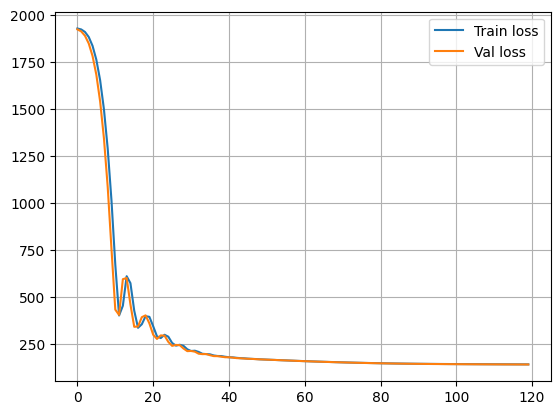

In [30]:
plt.plot(log.history["loss"], label="Train loss")
plt.plot(log.history["val_loss"], label="Val loss")
plt.legend()
plt.grid()

In [31]:
pred_train_nn = model.predict(x_train).round()
pred_test_nn = model.predict(x_test).round()
print(f"Train acc = {r2_score(y_train, pred_train_nn):.4f}, Test acc = {r2_score(y_test, pred_test_nn):.4f}")

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Train acc = 0.8542, Test acc = 0.8539
